In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test_labels.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv
/kaggle/input/glove840b300dtxt/glove.840B.300d.txt


In [2]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing import text,sequence
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,SimpleRNN,LSTM,SpatialDropout1D,GRU,Bidirectional,Input
from keras.layers.core import Dense,Activation,Dropout

D0910 12:41:42.406753908      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0910 12:41:42.406777281      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0910 12:41:42.406780961      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0910 12:41:42.406783718      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0910 12:41:42.406786289      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0910 12:41:42.406789250      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0910 12:41:42.406791851      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0910 12:41:42.

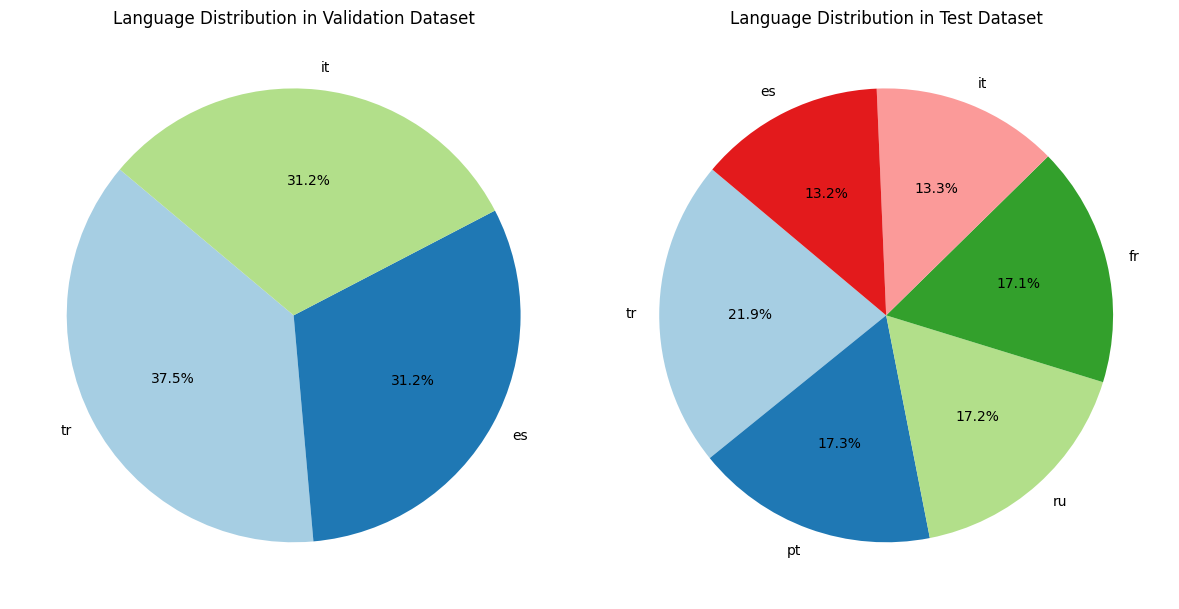

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load validation and test data (replace with actual file paths)
validation = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

# Get language distribution for validation and test datasets
validation_lang_distribution = validation['lang'].value_counts()
test_lang_distribution = test['lang'].value_counts()

# Plotting the distribution for validation dataset
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(validation_lang_distribution, labels=validation_lang_distribution.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Language Distribution in Validation Dataset')

# Plotting the distribution for test dataset
plt.subplot(1, 2, 2)
plt.pie(test_lang_distribution, labels=test_lang_distribution.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Language Distribution in Test Dataset')

# Save the figure
plt.tight_layout()
plt.savefig('language_distribution.png')  # Save as PNG file
plt.show()


In [ ]:
from tqdm import tqdm

In [ ]:
#configurint TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu.master())
except ValueError:
    tpu = None

In [ ]:
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    #default distribution strategy in tensorflow, Works on CPU and single GPU
    strategy = tf.distribute.TPUStrategy()

In [3]:
train = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

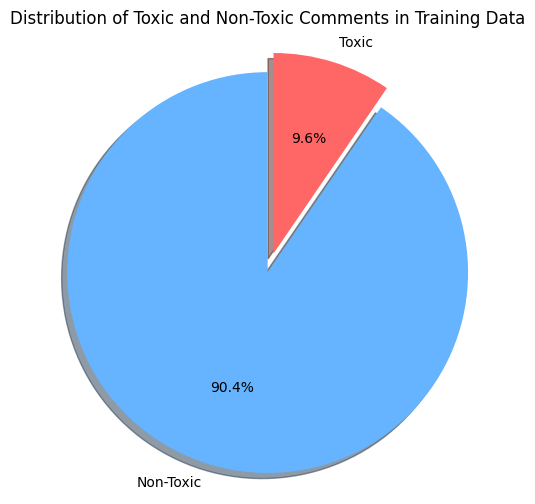

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file containing the comments and 'toxic' column
# Replace 'your_file.csv' with the path to your CSV file
# df = pd.read_csv('your_file.csv')

# Count the number of toxic and non-toxic comments
toxic_counts = train['toxic'].value_counts()

# Create a pie chart
labels = ['Non-Toxic', 'Toxic']
colors = ['#66b3ff', '#ff6666']  # Customize colors if you want
explode = (0.1, 0)  # Explode the first slice for emphasis

plt.figure(figsize=(6, 6))
plt.pie(toxic_counts, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Distribution of Toxic and Non-Toxic Comments in Training Data')
plt.axis('equal')  # Ensures the pie chart is a perfect circle

# Show the pie chart
plt.show()


In [ ]:
train.shape

In [ ]:
train.head()

In [ ]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis = 1, inplace = True)

In [ ]:
#check max len of comment_text column to use this for padding in future
pad_len = train['comment_text'].apply(lambda x:len(str(x).split())).max()
print('max len of comment_text column',pad_len)

# Data Preperation

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, stratify = train.toxic.values, random_state = 42,test_size = 0.2,shuffle = True)

In [ ]:
len(xtrain),len(xvalid)

# Tokenisation and Padding with max len of words in curpus

In [ ]:
test.head()

In [ ]:
#using keras tokenizer 
token = text.Tokenizer(num_words = None)
max_len = 2400
xtest = test.content.values
token.fit_on_texts(list(xtrain) + list(xvalid) + list(xtest))

x_train_seq = token.texts_to_sequences(xtrain)
x_valid_seq = token.texts_to_sequences(xvalid)
x_test_seq = token.texts_to_sequences(xtest)

#zero pad the sequences
x_train_pad = pad_sequences(x_train_seq,maxlen = max_len)
x_valid_pad = pad_sequences(x_valid_seq,maxlen = max_len)
x_test_pad = pad_sequences(x_test_seq,maxlen = max_len)
word_index = token.word_index

# 1: classification on basic RNN Network

In [ ]:
len(word_index) + 1

In [ ]:
%%time
with strategy.scope():
    
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

model.summary()

In [ ]:
#using strategy to run the TPU
model.fit(x_train_pad,ytrain,epochs = 5,batch_size = 64*strategy.num_replicas_in_sync)

In [ ]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import numpy as np

In [ ]:
pred_val = model.predict(x_valid_pad)

In [ ]:
model_accuracy = roc_auc_score(yvalid,pred_val)

In [ ]:
model_accuracy_ls = []
model_accuracy_ls.append({'model':'simpleRNN','AUC_SCORE':model_accuracy})

In [ ]:
model_accuracy_ls

# BERT Model

In [ ]:
!pip install transformers

In [ ]:
import transformers
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

# Tokenization

In [ ]:
# load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

#save the loaded tokenizer locally
tokenizer.save_pretrained('.')

#reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt',lowercase = False)
fast_tokenizer

In [ ]:
train.head()

In [ ]:
x_train = fast_encode(train.comment_text.astype(str), fast_tokenizer, maxlen=192)
x_valid = fast_encode(validation.comment_text.astype(str), fast_tokenizer, maxlen=192)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=192)

y_train = train.toxic.values
y_valid = validation.toxic.values

In [ ]:
BATCH_SIZE = 512
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [ ]:
def build_model(transformer, max_len=512):
    """
    funtion for training Bert Model
    """
    
    input_word_ids = Input(shape = (max_len,), dtype = tf.int32, name = "input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:,0,:]
    out = Dense(1, activation = 'sigmoid')(cls_token)
    model = Model(inputs = input_word_ids, outputs = out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
    
    

In [ ]:
# start model training 
with strategy.scope():
    transformer_layer = (
    transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer,max_len = 192)
model.summary()

In [ ]:
n_steps = x_train.shape[0] # BATCH_SIZE
train_history = model.fit(train_dataset,
                         steps_per_epoch = n_steps,
                         validation_data=valid_dataset,
                         epochs=2
                         )

In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_1 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=2*2
)

In [ ]:
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [ ]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)